# The goal of this model is to predict airplane arrival delays 1 week in advance based on flight data

In [34]:
import pandas as pd
import datetime
import psycopg2
import numpy as np
import matplotlib.pyplot as plt

In [35]:
#Connect to database with psycopg2
connection = psycopg2.connect(
    host="mid-term-project.ca2jkepgjpne.us-east-2.rds.amazonaws.com",
    database="mid_term_project",
    user="lhl_student",
    password="lhl_student",
    port=5432
)

In [36]:
#target variable is arr_delay. positive value means delay, negative value means early departure
df_flights = pd.read_sql_query('SELECT fl_date, mkt_carrier, origin, dest, crs_dep_time, crs_arr_time, crs_elapsed_time, arr_delay, distance, dest_city_name FROM flights ORDER BY RANDOM() LIMIT 60000;', connection)
df_flights.head()

,fl_date,mkt_carrier,origin,dest,crs_dep_time,crs_arr_time,crs_elapsed_time,arr_delay,distance,dest_city_name
0,2018-05-20,AA,FSD,DFW,700,919,139.0,122.0,737.0,"Dallas/Fort Worth, TX"
1,2018-11-23,UA,ORD,GSP,1750,2044,114.0,1.0,577.0,"Greer, SC"
2,2018-03-27,AS,DTW,PDX,820,1021,301.0,-16.0,1953.0,"Portland, OR"
3,2019-11-13,UA,BNA,IAH,840,1058,138.0,-20.0,657.0,"Houston, TX"
4,2019-06-13,UA,MFR,DEN,1235,1605,150.0,-22.0,964.0,"Denver, CO"


## Data Cleaning

In [37]:
#the only nulls are in arr_delay, which we assume is on time flight
#no need to drop/fill
df_flights.isnull().sum()

fl_date                0
mkt_carrier            0
origin                 0
dest                   0
crs_dep_time           0
crs_arr_time           0
crs_elapsed_time       0
arr_delay           1188
distance               0
dest_city_name         0
dtype: int64

In [38]:
#only concern is elapsed_time has negative values. everything else seems realistic
df_flights.describe()

,crs_dep_time,crs_arr_time,crs_elapsed_time,arr_delay,distance
count,60000.000000,60000.000000,60000.000000,58812.000000,60000.000000
mean,1329.493267,1482.984917,137.972583,5.618054,769.074683
std,490.858180,518.021876,71.718410,50.190570,587.771024
min,1.000000,1.000000,-35.000000,-175.000000,16.000000
25%,914.000000,1059.000000,87.000000,-15.000000,342.000000
50%,1321.000000,1510.000000,119.000000,-6.000000,603.000000
75%,1735.000000,1917.000000,167.000000,8.000000,1005.000000
max,2359.000000,2359.000000,685.000000,1421.000000,5095.000000


In [39]:
#how many negative elapsed time
df_flights[df_flights['crs_elapsed_time']<0]

,fl_date,mkt_carrier,origin,dest,crs_dep_time,crs_arr_time,crs_elapsed_time,arr_delay,distance,dest_city_name
40718,2018-01-31,DL,DTW,PHL,939,1130,-35.0,-175.0,453.0,"Philadelphia, PA"


In [40]:
#since it is just one outlier we can drop it
df_flights = df_flights[df_flights['crs_elapsed_time']>0]

## Exploratory Data Analysis

In [103]:
#try to identify any relationships between delay and any features.
#extract some categorical variables first such as month, day of week etc
df_delay = pd.read_sql_query('SELECT fl_date, mkt_carrier,mkt_carrier_fl_num,tail_num, origin, dest, crs_dep_time, crs_elapsed_time, distance,arr_delay,dep_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay FROM flights ORDER BY RANDOM() LIMIT 10000;', connection)
df_delay['total_delay'] = df_delay['dep_delay'] + df_delay['arr_delay'] + df_delay['carrier_delay'] + df_delay['weather_delay'] + df_delay['nas_delay'] + df_delay['security_delay'] + df_delay['late_aircraft_delay']
df_delay = df_delay.drop(columns=['dep_delay','carrier_delay','weather_delay','nas_delay','security_delay','late_aircraft_delay'])
df_delay['month'] = df_delay['fl_date'].apply(lambda x: int(x.split('-')[1]))
df_delay['day_of_week'] = df_delay['fl_date'].apply(get_day_of_week)
df_delay['total_delay'] = df_delay['total_delay'].fillna(0)
df_delay['dep_time'] = df_delay['crs_dep_time'].apply(lambda x: x//100)
df_delay['arr_delay_bins'] = df_delay['arr_delay'].apply(get_arr_delay)
df_delay.head()

,fl_date,mkt_carrier,mkt_carrier_fl_num,tail_num,origin,dest,crs_dep_time,crs_elapsed_time,distance,arr_delay,total_delay,month,day_of_week,dep_time,arr_delay_bins
0,2019-11-09,UA,6212,N85340,CLT,IAH,1038,175.0,912.0,-21.0,0.0,11,5,10,early
1,2018-10-11,WN,2535,N938WN,MCI,RDU,1905,140.0,904.0,-26.0,0.0,10,3,19,early
2,2019-01-27,AA,388,N905AU,DFW,DCA,709,171.0,1192.0,-15.0,0.0,1,6,7,early
3,2019-06-17,UA,539,N74856,SFO,OGG,1522,316.0,2338.0,-5.0,0.0,6,0,15,early
4,2019-11-24,UA,1980,N66897,IAH,MCO,1155,138.0,854.0,-14.0,0.0,11,6,11,early


Text(0.5, 0, 'Arr Delay')

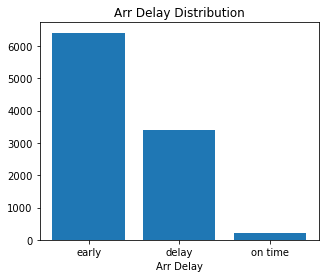

In [102]:
#what is the distrubtion of target variable arr_delay
#majority of flights are early. rarely on time
c = df_delay['arr_delay_bins'].value_counts()
plt.bar(c.index, c.values)
plt.title('Arr Delay Distribution')
plt.xlabel('Arr Delay')

Text(0, 0.5, 'Mean Delay')

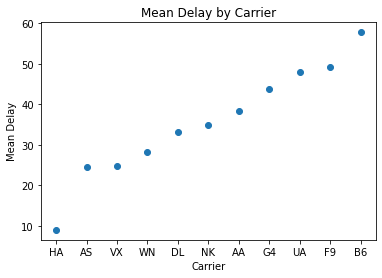

In [42]:
#Significant relationship. some Airlines have longer mean delay
a = df_delay[['mkt_carrier','total_delay']].groupby(df_delay['mkt_carrier']).mean().sort_values(by='total_delay')
plt.scatter(a.index,a.values)
plt.title('Mean Delay by Carrier')
plt.xlabel('Carrier')
plt.ylabel('Mean Delay')

Text(0, 0.5, 'Mean Delay')

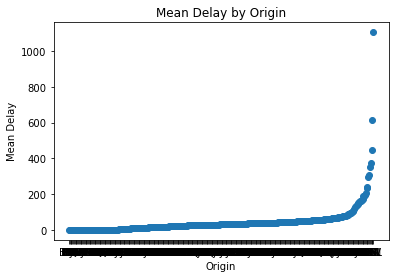

In [43]:
#origin airport probably not significant. seems like outliers
b = df_delay[['origin','total_delay']].groupby(df_delay['origin']).mean().sort_values(by='total_delay')
plt.scatter(b.index,b.values)
plt.title('Mean Delay by Origin')
plt.xlabel('Origin')
plt.ylabel('Mean Delay')

Text(0, 0.5, 'Mean Delay')

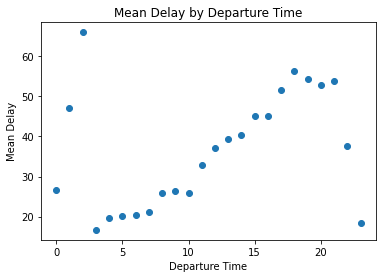

In [23]:
#significant relationship between departure time of day and mean delay
d = df_delay[['dep_time','total_delay']].groupby(df_delay['dep_time']).mean().sort_values(by='total_delay')
plt.scatter(d['dep_time'],d['total_delay'])
plt.title('Mean Delay by Departure Time')
plt.xlabel('Departure Time')
plt.ylabel('Mean Delay')

(-51.900000000000006, 500.0)

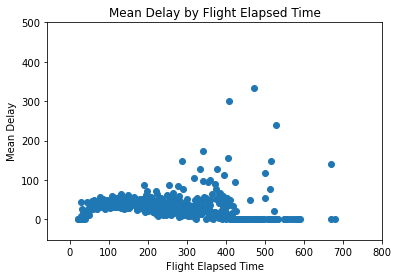

In [27]:
#insignificant
e = df_delay[['crs_elapsed_time','total_delay']].groupby(df_delay['crs_elapsed_time']).mean().sort_values(by='total_delay')
plt.scatter(e['crs_elapsed_time'],e['total_delay'])
plt.title('Mean Delay by Flight Elapsed Time')
plt.xlabel('Flight Elapsed Time')
plt.ylabel('Mean Delay')
plt.xlim(right=800)
plt.ylim(top=500)

Text(0, 0.5, 'Mean Delay')

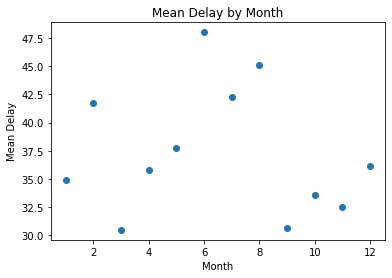

In [28]:
#seems significant by season. ie summer, winter
g = df_delay[['month','total_delay']].groupby(df_delay['month']).mean().sort_values(by='total_delay')
plt.scatter(g['month'],g['total_delay'])
plt.title('Mean Delay by Month')
plt.xlabel('Month')
plt.ylabel('Mean Delay')

Text(0, 0.5, 'Mean Delay')

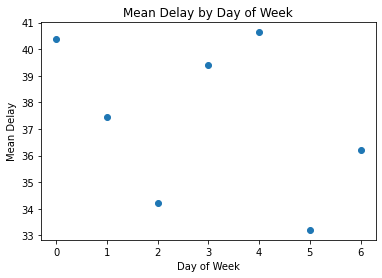

In [29]:
#seems significant by weekday/weekend
h = df_delay[['day_of_week','total_delay']].groupby(df_delay['day_of_week']).mean().sort_values(by='total_delay')
plt.scatter(h['day_of_week'],h['total_delay'])
plt.title('Mean Delay by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Mean Delay')

#### Now that some relationships have been identified, they will be engineered into features to hopefully boost our models accuracy

## Feature Engineering

In [44]:
#getter functions
def get_day_of_week(x):
    a = int(x.split('-')[0])
    b = int(x.split('-')[1])
    c = int(x.split('-')[2])
    dt = datetime.datetime(a,b,c)
    return dt.weekday()

def get_flight_length(x):
    if x < 180:
        return 'short'
    elif x > 360:
        return 'long'
    else:
        return 'medium'
    
def get_traffic(x):
    if x < 700:
        return 'quiet'
    elif x > 4200:
        return 'busy'
    else:
        return 'moderate'
    
def get_arr_delay(x):
    if x > 0:
        return 'delay'
    elif x == 0:
        return 'on time'
    else:
        return 'early'
    
def get_season(x):
    if x > 5 and x < 9:
        return 'summer'
    elif x > 8 and x < 12:
        return 'fall'
    elif x < 6 and x > 2:
        return 'spring'
    else:
        return 'winter'

def get_dep_time_cat(x):
    if x > 1 and x < 10:
        return 'morning'
    elif x > 9 and x < 18:
        return 'afternoon'
    else:
        return 'evening'

In [45]:
#airport foot traffic feature from passengers table
df_traffic = pd.read_sql_query('SELECT origin, dest, passengers, month FROM passengers ORDER BY RANDOM() LIMIT 60000;', connection)
df_traffic.head()

,origin,dest,passengers,month
0,DTW,DFW,696.0,11
1,SHG,OTZ,0.0,12
2,SXP,BET,8.0,3
3,PBI,DCA,2499.0,9
4,FLL,MIA,43.0,10


In [46]:
#create features based on bining into categorical variables
df_features = df_flights.copy()[['mkt_carrier','origin','dest','arr_delay','distance']]
df_features['month'] = df_flights['fl_date'].apply(lambda x: int(x.split('-')[1]))
df_features['day_of_week'] = df_flights['fl_date'].apply(get_day_of_week)
df_features['departure_time'] = df_flights['crs_dep_time'].apply(lambda x: x//100)
df_features['flight_length'] = df_flights['crs_elapsed_time'].apply(get_flight_length)
df_features = pd.merge(df_features,df_traffic, on=['origin','dest','month'])
df_features['passengers'] = df_features['passengers'].replace(0, np.nan).dropna(axis=0, how='any')
df_features['airport_traffic'] = df_features['passengers'].apply(get_traffic)
df_features = df_features.drop(columns=['passengers'])
df_features['distance'] = df_features['distance'].apply(lambda x: x//10)
df_features['arr_delay'] = df_features['arr_delay'].apply(get_arr_delay)
df_features['weekday_weekend'] = df_features['day_of_week'].apply(lambda x: 'weekend' if x > 4 else 'weekday')
df_features['season'] = df_features['month'].apply(get_season)
df_features['departure_time_cat'] = df_features['departure_time'].apply(get_dep_time_cat)
df_features.head()

,mkt_carrier,origin,dest,arr_delay,distance,month,day_of_week,departure_time,flight_length,airport_traffic,weekday_weekend,season,departure_time_cat
0,AA,FSD,DFW,delay,73.0,5,6,7,short,moderate,weekend,spring,morning
1,AA,FSD,DFW,delay,73.0,5,6,7,short,moderate,weekend,spring,morning
2,UA,ORD,GSP,delay,57.0,11,4,17,short,quiet,weekday,fall,afternoon
3,UA,ORD,GSP,early,57.0,11,0,14,short,quiet,weekday,fall,afternoon
4,UA,BNA,IAH,early,65.0,11,2,8,short,quiet,weekday,fall,morning


## Encode

In [ ]:
#categorical encoding using pandas get_dummies

In [122]:
df = df_features.copy()
df.head()

,mkt_carrier,origin,dest,arr_delay,distance,month,day_of_week,departure_time,flight_length,airport_traffic,weekday_weekend,season,departure_time_cat
0,AA,FSD,DFW,delay,73.0,5,6,7,short,moderate,weekend,spring,morning
1,AA,FSD,DFW,delay,73.0,5,6,7,short,moderate,weekend,spring,morning
2,UA,ORD,GSP,delay,57.0,11,4,17,short,quiet,weekday,fall,afternoon
3,UA,ORD,GSP,early,57.0,11,0,14,short,quiet,weekday,fall,afternoon
4,UA,BNA,IAH,early,65.0,11,2,8,short,quiet,weekday,fall,morning


In [123]:
pd.get_dummies(df)

,distance,month,day_of_week,departure_time,mkt_carrier_AA,mkt_carrier_AS,mkt_carrier_B6,mkt_carrier_DL,mkt_carrier_F9,mkt_carrier_G4,...,airport_traffic_quiet,weekday_weekend_weekday,weekday_weekend_weekend,season_fall,season_spring,season_summer,season_winter,departure_time_cat_afternoon,departure_time_cat_evening,departure_time_cat_morning
0,73.0,5,6,7,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,1
1,73.0,5,6,7,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,1
2,57.0,11,4,17,0,0,0,0,0,0,...,1,1,0,1,0,0,0,1,0,0
3,57.0,11,0,14,0,0,0,0,0,0,...,1,1,0,1,0,0,0,1,0,0
4,65.0,11,2,8,0,0,0,0,0,0,...,1,1,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53067,142.0,6,5,11,0,0,0,1,0,0,...,1,0,1,0,0,1,0,1,0,0
53068,142.0,6,5,11,0,0,0,1,0,0,...,0,0,1,0,0,1,0,1,0,0
53069,142.0,6,5,11,0,0,0,1,0,0,...,0,0,1,0,0,1,0,1,0,0
53070,78.0,3,4,12,0,0,0,0,0,1,...,1,1,0,0,1,0,0,1,0,0


In [116]:
x = df_features.dtypes
for i in x:
    print(i)

object
object
object
object
float64
int64
int64
int64
object
object
object
object
object
